In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import glob
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os
import sys

In [ ]:
breeds = pd.read_csv('../input/breed_labels.csv')
colors = pd.read_csv('../input/color_labels.csv')
states = pd.read_csv('../input/state_labels.csv')

train = pd.read_csv('../input/train/train.csv')
test = pd.read_csv('../input/test/test.csv')
sub = pd.read_csv('../input/test/sample_submission.csv')

In [ ]:
with tf.Session() as sess:
    devices = sess.list_devices()
devices

In [ ]:
train.head()

## Image Data

In [ ]:
train_image_files = sorted(glob.glob('../input/train_images/*.jpg'))
train_metadata_files = sorted(glob.glob('../input/train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob('../input/train_sentiment/*.json'))

print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))


test_image_files = sorted(glob.glob('../input/test_images/*.jpg'))
test_metadata_files = sorted(glob.glob('../input/test_metadata/*.json'))
test_sentiment_files = sorted(glob.glob('../input/test_sentiment/*.json'))

print('num of test images files: {}'.format(len(test_image_files)))
print('num of test metadata files: {}'.format(len(test_metadata_files)))
print('num of test sentiment files: {}'.format(len(test_sentiment_files)))

In [ ]:
train_df_ids = train['PetID']

train_df_imgs = pd.DataFrame(train_image_files)
#print(train_df_imgs.head())
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_imgs = train_df_imgs.assign(PetID=train_imgs_pets)

train_image = train.merge(train_df_imgs, on='PetID', how='outer')
train_image = train_image.dropna()
#print(train_df_imgs.head())
print(train_image.head())

In [ ]:
test_df_ids = test[['PetID']]

test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_imgs = test_df_imgs.assign(PetID=test_imgs_pets)

test_image = test.merge(test_df_imgs, on='PetID', how='outer')
test_image = test_image[['PetID', 'image_filename']].dropna()
test_image['AdoptionSpeed'] = 0

In [ ]:
#plt.imshow(cv2.imread(train_image['image_filename'][0]))
#plt.show()
plt.imshow(cv2.imread(test_image['image_filename'][0]))
plt.show()

In [ ]:
X = np.zeros([len(train_image), 128, 128, 3],dtype = np.int8)
Type = np.zeros(len(train_image),dtype = np.int8)
Speed = np.zeros(len(train_image),dtype = np.int8)

for i in tqdm_notebook(range(len(train_image))):
        img = cv2.imread(train_image['image_filename'].iloc[i])
        n = max(img.shape[:2])
        x_pad = n//2 - img.shape[1]//2 
        y_pad = n//2 - img.shape[0]//2
        #img = img[startx:startx+n, starty:starty+n]
        img = cv2.copyMakeBorder(img, y_pad, y_pad, x_pad, x_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        X[i] = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)-128
        Type[i] = train_image['Type'].iloc[i]
        Speed[i] = train_image['AdoptionSpeed'].iloc[i]

## Spark Image Processing (Optional)

In [ ]:
from pyspark import SparkConf, SparkContext

In [ ]:
conf = SparkConf()
sc = SparkContext(conf=conf)


In [ ]:
def resizeImage(image_file_name):
    img = cv2.imread(image_file_name)
    n = max(img.shape[:2])
    x_pad = n//2 - img.shape[1]//2 
    y_pad = n//2 - img.shape[0]//2
    img = cv2.copyMakeBorder(img, y_pad, y_pad, x_pad, x_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)-128

rdd = sc.parallelize(train_image_files,3)
rdd2 = rdd.flatMap(
    lambda x: resizeImage(x)
)
print(rdd2.take(2))

[[[128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [128 128 128]
  [144 150 145]
  [143 149 144]
  [142 148 143]
  [141 147 142]
  [143 149 144]
  [144 150 145]
  [145 151 146]
  [145 151 146]
  [145 151 146]
  [141 148 143]
  [141 149 147]
  [136 140 138]
  [220 219 210]
  [ 70  69  58]
  [ 73  69  55]
  [ 77  74  59]
  [236 237 226]
  [146 151 145]
  [143 149 144]
  [143 149 144]
  [140 146 141]
  [141 147 142]
  [146 152 147]
  [143 148 146]
  [142 147 146]
  [147 152 151]
  [150 152 149]
  [154 158 152]
  [151 156 150]
  [154 158 154]
  [144 155 148]
  [149 156 155]
  [151 156 157]
  [150 157 151]
  [159 168 157]
  [158 172 161]
  [169 183 172]
  [194 208 197]
  [220 234 223]
  [237 248 238]
  [237 248 238]
  [231 242 232]
  [225 236 226]
  [221 230 227]
  [223 232 229]
  [222 2

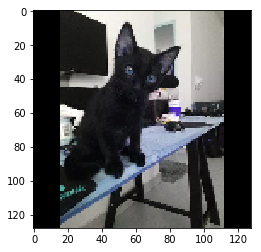

In [74]:
plt.imshow((X[0]+128)/255)
plt.show()

In [ ]:
X_feature = train_image[['Type','Age','Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','FurLength','Vaccinated','Dewormed',
      'Sterilized','Health','Quantity','Fee','State','VideoAmt','PhotoAmt']].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Speed, test_size=0.1, random_state = 42)
X_train_feature, X_test_feature, type_train, type_test = train_test_split(X_feature, Type, test_size=0.1, random_state = 42)

In [ ]:
X_train_feature.shape

## Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Add, Input, Lambda, concatenate, BatchNormalization
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.models import Model

In [ ]:
model = Sequential()

model.add(Lambda(lambda x: (x/255+0.5)))
# model.add(Conv2D(32, (3, 3)))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3,3)))
# model.add(Conv2D(64, (3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3,3)))
# model.add(Conv2D(128, (3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,kernel_initializer='zeros',bias_initializer='zeros'))
#model.add(Activation('softmax'))
# model.compile(loss='mean_absolute_error',
#           optimizer='adam', metrics=['mean_absolute_error'])

model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Wrap Model

In [ ]:
image_input = Input(shape=(128,128,3))

x1 = Lambda(lambda x: (x/255+0.5))(image_input)
x1 = Conv2D(32, (3, 3))(x1)
x1 = Conv2D(32, (3, 3))(x1)
x1 = Activation('relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(64, (3, 3))(x1)
x1 = Conv2D(64, (3, 3))(x1)
x1 = Activation('relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(128, (3, 3))(x1)
x1 = Conv2D(128, (3, 3))(x1)
x1 = Activation('relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Flatten()(x1)
x1 = Dense(256)(x1)
x1 = Activation('relu')(x1)
x1 = Dense(32)(x1)
x1 = Activation('relu')(x1)
x1 = Dropout(0.5)(x1)
x1 = BatchNormalization()(x1)

feature_input = Input(shape = (19, ), dtype = 'float', name = 'feature_input')
x2 = Dense(32)(feature_input)
x2 = BatchNormalization()(x2)

x = concatenate([x1, x2])
x = Dense(32)(x)
x = Activation('relu')(x)
out = Dense(1,kernel_initializer='zeros',bias_initializer='zeros')(x)
out = Activation('sigmoid')(out)

model1 = Model(inputs=[image_input, feature_input], outputs= out)

# model1.compile(loss='binary_crossentropy', loss_weights=[1., 0],
#               optimizer='rmsprop',
#               metrics=['accuracy'])

model1.compile(loss='mean_absolute_error',
          optimizer='adam', metrics=['mean_absolute_error'])

In [ ]:
model1.fit([X_train, X_train_feature], y_train, epochs=2, batch_size=64)
model1.evaluate([X_test, X_test_feature], y_test)

In [ ]:
sum(y_test == (model1.predict([X_test, X_test_feature])+0.5).astype(np.int).reshape(-1))/len(y_test)

## Image to Vector

In [ ]:
image_input = Input(shape=(128,128,3))

x1 = Lambda(lambda x: (x/255+0.5))(image_input)
x1 = Conv2D(32, (3, 3))(x1)
x1 = Conv2D(32, (3, 3))(x1)
x1 = Activation('relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(64, (3, 3))(x1)
x1 = Conv2D(64, (3, 3))(x1)
x1 = Activation('relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Conv2D(128, (3, 3))(x1)
x1 = Conv2D(128, (3, 3))(x1)
x1 = Activation('relu')(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1)

x1 = Flatten()(x1)
x1 = Dense(256)(x1)
x1 = Activation('relu')(x1)
x1 = Dense(64)(x1)
x1 = Activation('relu')(x1)

out = Dropout(0.5)(x1)
out = Dense(1,kernel_initializer='zeros',bias_initializer='zeros')(out)
out = Activation('sigmoid')(out)

model2 = Model(inputs=image_input, outputs=[out, x1])
#out is the binary output of the type (cat vs dog), while x1 is a 256-dimensions vector
#includes the information of the image

model2.compile(loss='binary_crossentropy', loss_weights=[1., 0],
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
model2.fit(X_train, [type_train-1, np.zeros([len(X_train), 256])], epochs=10, batch_size=64)
model2.evaluate(X_test, [type_test-1, np.zeros([len(X_test), 256])], epochs=10, batch_size=64)

In [ ]:
train_image_vector = model2.predict(X_train)[1]

In [ ]:
test_image_vector = model2.predict(X_test)[1]

In [ ]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(train_image_vector, y_train)
#lg.score(train_image_vector, y_train)

In [ ]:
lg.score(test_image_vector, y_test)

In [ ]:
lg.predict_proba(test_image_vector)

In [ ]:
lg1 = LogisticRegression()
lg1.fit(X_train_feature, y_train)
lg1.score(X_test_feature, y_test)

In [ ]:
np.mean(np.argmax(lg.predict_proba(test_image_vector) + lg1.predict_proba(X_test_feature), axis = 1) == y_test)

## Predict on Test set

In [ ]:
# (model.predict(X_test)+0.5).astype(np.int)[:10]

In [ ]:
# X_ = np.zeros([len(test_image), 128, 128, 3],dtype = np.int8)

# for i in tqdm_notebook(range(len(test_image))):
#     img = cv2.imread(test_image['image_filename'].iloc[i])
#     n = max(img.shape[:2])
#     x_pad = n//2 - img.shape[1]//2 
#     y_pad = n//2 - img.shape[0]//2
#     #img = img[startx:startx+n, starty:starty+n]
#     img = cv2.copyMakeBorder(img, y_pad, y_pad, x_pad, x_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
#     X_[i] = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)-128

In [ ]:
# pred = model.predict(X_)
# pred = (pred+0.5).astype(np.int)

# test_image['AdoptionSpeed'] = pred
# d = {'AdoptionSpeed': 'mean'}
# agg = test_image.groupby('PetID', as_index=False).aggregate(d)
# agg['AdoptionSpeed'] = np.rint(agg['AdoptionSpeed']).astype(int)
# submission = test.merge(agg, on = 'PetID', how = 'outer')[['PetID', 'AdoptionSpeed']].fillna(3)
# submission['AdoptionSpeed'] = submission['AdoptionSpeed'].astype(int)
# submission.to_csv('submission.csv', index=False)